# attempt to reproduce the GCNN paper

do a stupid CNN implementation on mnist first

## load the digits dataset

In [1]:
import torch
import torch.nn.functional as F
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import torch.nn as nn

from torch.optim import SGD
from sklearn.datasets import fetch_openml
import numpy as np

import time

In [2]:
device = torch.device("mps")

In [3]:
ds = load_digits()
digits = torch.tensor(ds.data)

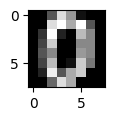

In [4]:
plt.figure(figsize=(1,1))
plt.imshow(digits.view(-1, 8, 8)[0], cmap='gray')

In [8]:
padded = F.pad(digits.view(-1, 8, 8)[0], (3, 3, 3, 3))
padded.shape

torch.Size([14, 14])

In [9]:
digits.view(-1, 8, 8)[0].shape

torch.Size([8, 8])

In [5]:
ds.target[0].item()

0

In [6]:
# hooray reshape it 
Xs = digits #.view(-1, 8, 8)
Xs.shape

torch.Size([1797, 64])

In [7]:
# one-hot the output
Ycl = torch.tensor(ds.target)
n_classes = Ycl.unique().shape[0]
Ys = F.one_hot(Ycl, n_classes)

## tts

In [8]:
# cast
Xs = Xs.float() / 16.0
Ys = Ys.float()

In [9]:
N = Ys.shape[0]

i1 = int(0.8 * N)
i2 = int(0.9 * N)

Xtr, Ytr = Xs[:i1].to(device), Ys[:i1].to(device)
Xdv, Ydv = Xs[i1:i2].to(device), Ys[i1:i2].to(device)
Xte, Yte = Xs[i2:].to(device), Ys[i2:].to(device)

In [10]:
def calc_loss(split: str):
    Xs, Ys = {
        "train": (Xtr, Ytr),
        "val":   (Xdv, Ydv),
        "test":  (Xte, Yte),
    }[split]
    with torch.no_grad():
        Yhat = network.forward(Xs)
        loss = F.cross_entropy(Yhat, Ys)
        print(f"{split} loss = {loss.item():.4f}")

## stupid cnn architecture

In [11]:
# what is the expected loss, assuming equally-likely outputs?
stupid_logits = torch.tensor([0.0] * 10)
stupid_logits[0] = 0.0
stupid_counts = stupid_logits.exp()
stupid_probs = stupid_counts / stupid_counts.sum(0, keepdim=True)

# neg log likelihood
-stupid_probs[0].log()

tensor(2.3026)

In [12]:
G  = torch.Generator().manual_seed(2147483647)

class SingleLayer(nn.Module):
    def __init__(self):

        super().__init__()
        
        self.im_sidelen: int   = 8
        self.input_dim: int    = self.im_sidelen**2
        self.output_dim: int   = n_classes
        
        self.kernel_size: int  = 5
        self.padding: int      = 2

        self.kernel_size2: int = 3
        self.padding2: int     = 1

        # (n, 8, 8) -> (n, 2, 8, 8)
        self.conv1 = nn.Conv2d(1, 2, kernel_size=self.kernel_size, padding=self.padding)

        # (n, 2, 8, 8) -> (n, 2, 8, 8)
        self.bn1 = nn.BatchNorm2d(2)
        
        # (n, 2, 8, 8) -> (n, 2, 4, 4)
        self.pool1 = nn.MaxPool2d(2)

        # (n, 2, 4, 4) -> (n, 4, 4, 4)
        self.conv2 = nn.Conv2d(2, 4, kernel_size=self.kernel_size2, padding=self.padding2)

        # (n, 4, 4, 4) -> (n, 4, 4, 4)
        self.bn2 = nn.BatchNorm2d(4)

        # (n, 4, 4, 4) -> (n, 4, 2, 2)
        self.pool2 = nn.MaxPool2d(2)
        
        # (n, 4, 4, 4) -> (n, 16) -> (n, 16)
        self.W1 = nn.Linear(16, 10)

        self.layers = [
            self.conv1, self.bn1, self.pool1,
            self.conv2, self.bn2, self.pool2,
            self.W1
        ]
        
        # "principled" initializations
        g = nn.init.calculate_gain("relu")
        nn.init.xavier_uniform_(self.W1.weight, gain=g, generator=G)
        nn.init.uniform_(self.bn1.weight, generator=G)
        nn.init.uniform_(self.bn2.weight, generator=G)
        nn.init.zeros_(self.bn1.bias)
        nn.init.zeros_(self.bn2.bias)
        
        # nn.init.xavier_uniform_(self.W2.weight, gain=g, generator=G)

    def forward(self, x):
        pool1 = self.conv1(x.view(-1, 1, self.im_sidelen, self.im_sidelen))
        pool1 = self.pool1(pool1)
        pool1 = self.bn1(pool1)              
        pool1 = F.relu(pool1)

        pool1 = F.dropout(pool1, p=0.2)
        
        pool2 = self.conv2(pool1)
        pool2 = self.pool2(pool2)
        pool2 = self.bn2(pool2)        
        pool2 = F.relu(pool2)

        pool2 = F.dropout(pool2, p=0.2)
        
        h1 = F.relu(self.W1(pool2.view(-1, 16)))

        return h1       

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None



In [13]:
N

1797

In [14]:
# train loop
epochs = 200_000

losses = []
times = []

lr = 0.1
network = SingleLayer()
network.to(device)

sgd = SGD(network.parameters(), lr=0.1)

last_time = time.time()

for i in range(epochs):
    # build minibatch
    last_time = time.time()

    # empirically:
    # BS ~=  32 --> 4ms/epoch @ MPS,  1ms/epoch @ CPU
    # BS ~= 512 --> 4ms/epoch @ MPS,  5ms/epoch @ CPU
    # BS ~= 768 --> 5ms/epoch @ MPS, 10ms/epoch @ CPU
    # need to profile this more w/ torch.mps to see what
    # cache line we are saturating
    batch_size = 256*3
    idxs = torch.randint(0, i1, (batch_size,))
    Xb = Xtr[idxs]
    Yb = Ytr[idxs]

    # forward pass
    Yhat = network.forward(Xb)
    loss = F.cross_entropy(Yhat, Yb)
    losses.append(loss)

    # backward pass
    network.zero_grad()
    loss.backward()
    # sgd.step()

    Dt = time.time() - last_time
    times.append(Dt)

    # update
    with torch.no_grad():
        for _, p in enumerate(network.parameters()):
            # print(p.grad)
            # grads.setdefault(i, []).append(p.grad.tolist())
            p.data = p.data - p.grad*lr 
    
    # stats
    if i % 1_000 == 0:
        print(f"{i:8d}/{epochs:8d}: loss={loss:.4f}. device={Xb.device}. avg epoch time={np.mean(np.array(times)):.6f}")        
    
calc_loss("train")
calc_loss("val")
print(f"on device {Xb.device}, avg epoch time was {np.mean(np.array(times)):.6f}")


       0/  200000: loss=2.5596. device=mps:0. avg epoch time=0.143074
    1000/  200000: loss=0.6971. device=mps:0. avg epoch time=0.003639
    2000/  200000: loss=0.6092. device=mps:0. avg epoch time=0.003520
    3000/  200000: loss=0.6056. device=mps:0. avg epoch time=0.003494
    4000/  200000: loss=0.6102. device=mps:0. avg epoch time=0.003493
    5000/  200000: loss=0.5551. device=mps:0. avg epoch time=0.003493
    6000/  200000: loss=0.5456. device=mps:0. avg epoch time=0.003483
    7000/  200000: loss=0.5297. device=mps:0. avg epoch time=0.003479
    8000/  200000: loss=0.5164. device=mps:0. avg epoch time=0.003471
    9000/  200000: loss=0.4632. device=mps:0. avg epoch time=0.003464
   10000/  200000: loss=0.4692. device=mps:0. avg epoch time=0.003470
   11000/  200000: loss=0.5171. device=mps:0. avg epoch time=0.003466
   12000/  200000: loss=0.4896. device=mps:0. avg epoch time=0.003462
   13000/  200000: loss=0.5022. device=mps:0. avg epoch time=0.003461
   14000/  200000: l

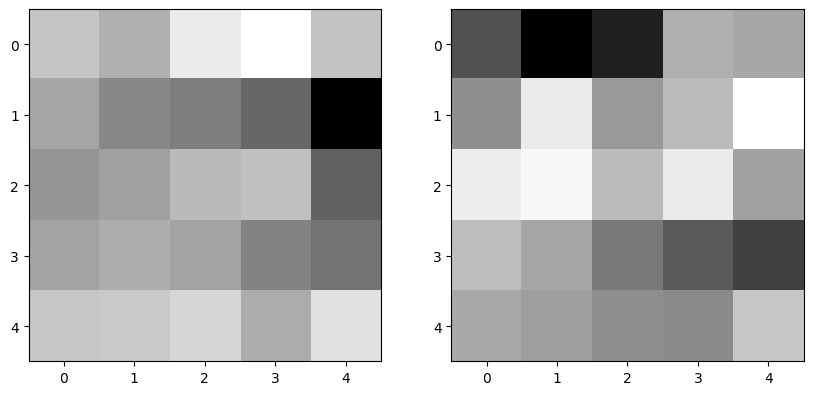

In [15]:
# visualize the kernels
plt.figure(figsize=(10, 5))
with torch.no_grad():
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.imshow(network.conv1.weight[i].view(5, 5).cpu(), cmap='gray')

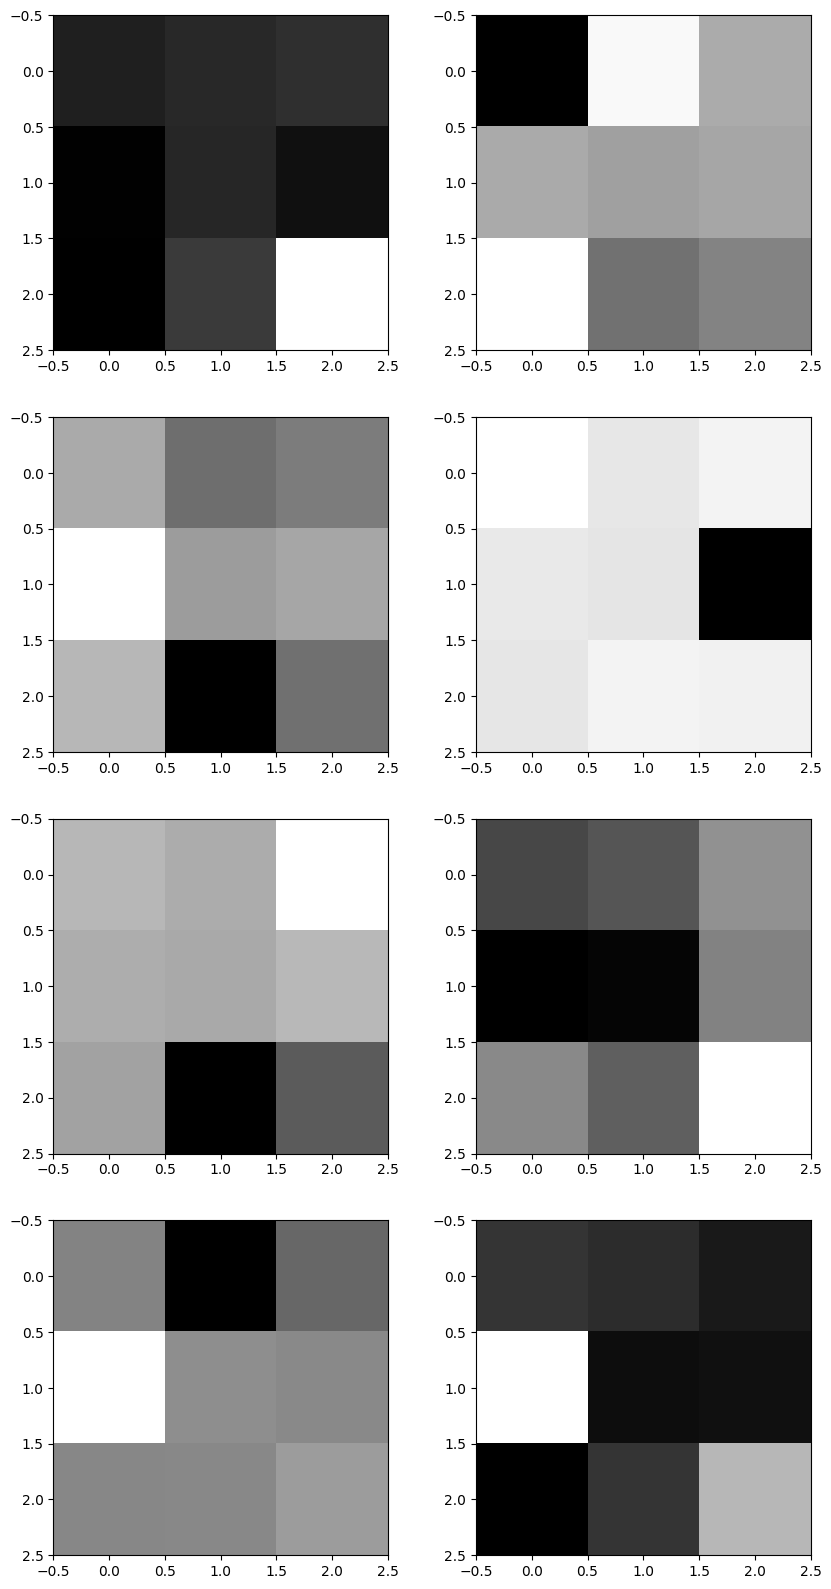

In [16]:
# visualize the kernels
plt.figure(figsize=(10, 20))
with torch.no_grad():
    for i in range(8):
        plt.subplot(4, 2, i+1)
        in_id = i // 2
        out_id = i % 2
        plt.imshow(network.conv2.weight[in_id, out_id].view(3, 3).cpu(), cmap='gray')

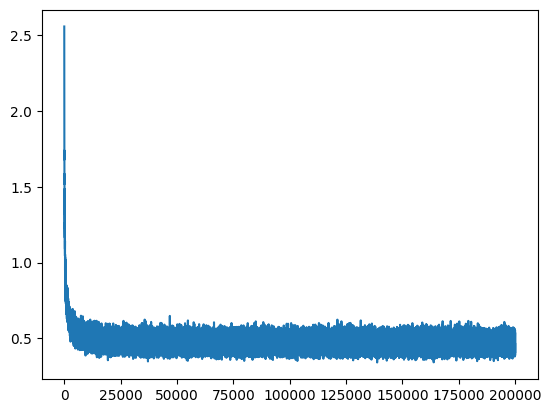

In [17]:
plt.plot(torch.tensor(losses));

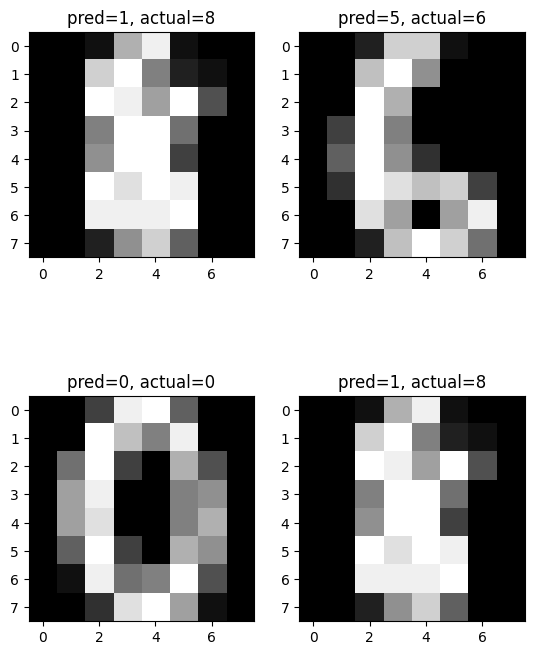

In [18]:
idx = torch.randint(0, Xte.shape[0], (4,))
Xs, Ys = Xte[idx], Yte[idx]
Yhat = torch.argmax(network.forward(Xs), dim=1)
for i, X in enumerate(Xs):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(top=1.5)
    plt.imshow(X.view(8, 8).cpu(), cmap='gray')
    ystar = torch.argmax(Ys[i])
    yhat = Yhat[i]
    plt.title(f"pred={yhat}, actual={ystar}")